In [1]:
import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
import keras
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
import tensorflow as tf
color = sns.color_palette()
%matplotlib inline

#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

In [2]:
# отключение рандомизации хэша
os.environ['PYTHONHASHSEED'] = '0'

np.random.seed(111)

# Отключает многопоточность в tensorflow (если она не поддерживается)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

tf.compat.v1.set_random_seed(111)

# сессия tf
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

# передаем сессию в керас
K.set_session(sess)

aug.seed(111)

In [3]:
# путь к всему набору
data_dir = Path('../datasets/chest_xray/chest_xray')

# набор для обучения
train_dir = data_dir / 'train'

# для проверки
val_dir = data_dir / 'val'

# для теста
test_dir = data_dir / 'test'

In [4]:
# путь к разным классам
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# получаем изображения
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

train_data = []

# передаем изображения в список train_data, устанавливаем метки 0 для здоровых и 1 для больных
for img in normal_cases:
    train_data.append((img,0))

for img in pneumonia_cases:
    train_data.append((img, 1))

# создаем pandas dataframe - двумерный массив из изображений и меток для дальнейшей работы
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# перемешаем изображения
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# смотрим что получилось
train_data.head()

,image,label
0,..\datasets\chest_xray\chest_xray\train\NORMAL...,0
1,..\datasets\chest_xray\chest_xray\train\NORMAL...,0
2,..\datasets\chest_xray\chest_xray\train\PNEUMO...,1
3,..\datasets\chest_xray\chest_xray\train\PNEUMO...,1
4,..\datasets\chest_xray\chest_xray\train\PNEUMO...,1


Здоровых:  1341 
 Больных:  3875


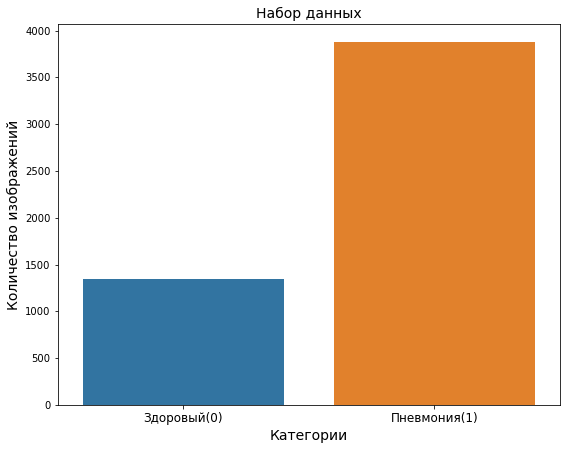

In [5]:
# подсчет случаев в каждом классе
cases_count = train_data['label'].value_counts()
print('Здоровых: ', cases_count[0],'\n', 'Больных: ', cases_count[1])

# визуализируем 
plt.figure(figsize=(9,7))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Набор данных', fontsize=14)
plt.xlabel('Категории', fontsize=14)
plt.ylabel('Количество изображений', fontsize=14)
plt.xticks(range(len(cases_count.index)), ['Здоровый(0)', 'Пневмония(1)'], fontsize=12)
plt.show()

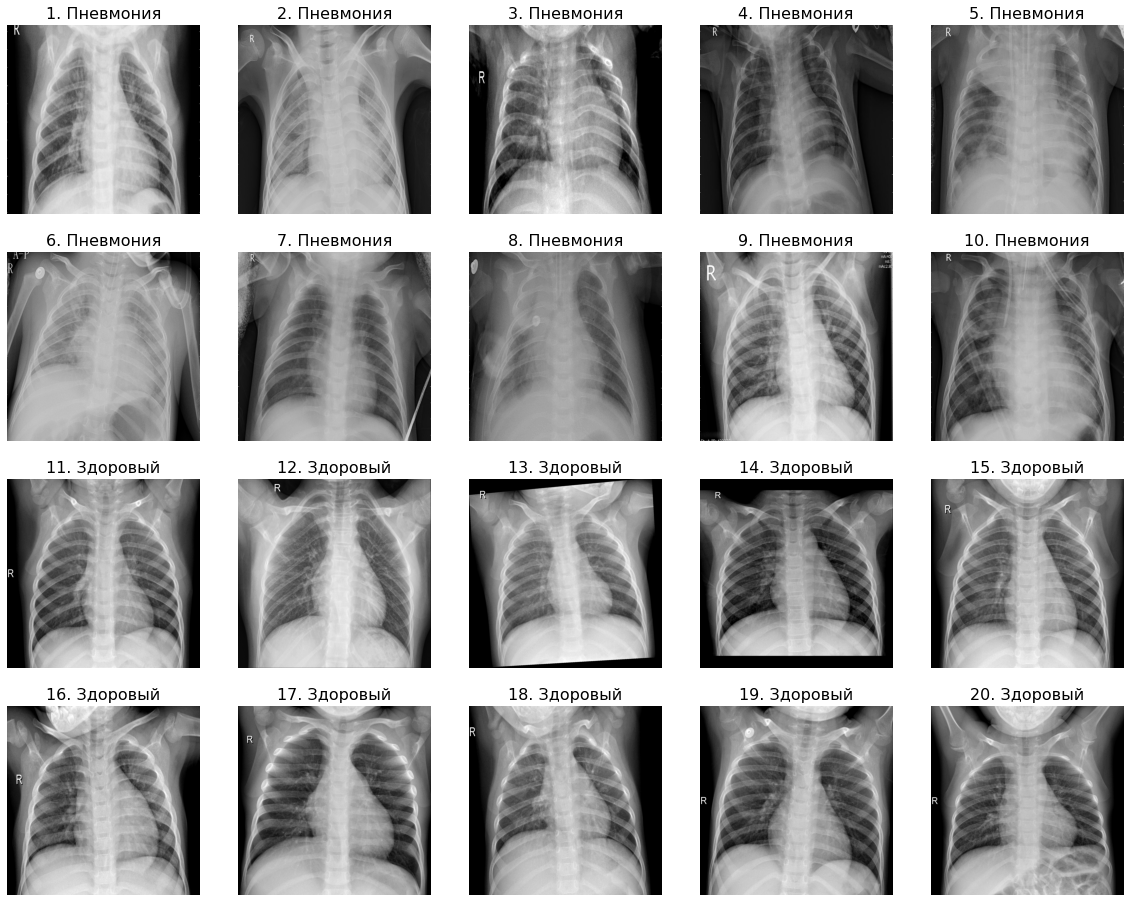

In [6]:
# примеры изображений
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:10]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:10]).tolist()

# объединяем в один список 
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# визуализируем
f, ax = plt.subplots(4,5, figsize=(20,16))
for i in range(len(samples)):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<(len(samples))/2:
        ax[i//5, i%5].set_title("{}. Пневмония".format(i+1), fontsize=16)
    else:
        ax[i//5, i%5].set_title("{}. Здоровый".format(i+1), fontsize=16)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [7]:
# путь к проверочным изображениям
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

# получаем изображения
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

valid_data = []
valid_labels = []

# приведем все проверочные данные к одному виду
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
                           
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
    
# создаем массив нумпай
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Изображений для проверки: ", valid_data.shape[0])

Изображений для проверки:  16


In [8]:
# определяем увеличение данных
seq = iaa.OneOf([
    iaa.Fliplr(), # переворачиваем по горизонтали
    iaa.Affine(rotate=20), # меняем угол наклона
    iaa.Multiply((1.2, 1.5))]) # выставляем случайную яркость

In [9]:
#генератор для данных
def data_gen(data, batch_size):
    n = len(data)
    steps = n//batch_size
    
    # создаем нумпай массив для хранения
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)

    # получаем массив индексов
    indices = np.arange(n)
    
    i =0
    while True:
        np.random.shuffle(indices)
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            encoded_label = to_categorical(label, num_classes=2)

            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
            
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # увеличение данных
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

In [10]:
# создаем модель
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(2, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [11]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0     

In [12]:
# путь к файлам с весами VGG16
f = h5py.File('../models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

# выбираем слои, в которые загрузим веса (это пара первых слоев свертки)

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary()  

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0     

In [13]:
# устанавливаем гиперпараметры
opt = Adam(learning_rate=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [14]:
batch_size = 16
nb_epochs = 20

# вызываем генератор
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# количество шагов за эпоху (обычно вычисляют именно так)
nb_train_steps = train_data.shape[0]//batch_size

print("Количество шагов для обучения и проверки: {} и {} соответственно".format(nb_train_steps, len(valid_data)))

Количество шагов для обучения и проверки: 326 и 16 соответственно


In [15]:
# обучение модели
#history = model.fit(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
#                               validation_data=(valid_data, valid_labels),callbacks=[es, chkpt],
#                               class_weight={0:1.0, 1:0.4})
#
#model.save("../models/pneumo_model3.h5")

In [16]:
# сохраняем веса и модель
#model.save_weights('../models/my_pneumo_weights.h5')
#model.load_weights("../models/my_pneumo_weights.h5")

# загружаем сохраненную модель
model = keras.models.load_model(r'../models/pneumo_model1.h5')

In [17]:
# готовим тестовые данные
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Изображений для тестирования: ", test_data.shape[0])

Изображений для тестирования:  624


In [18]:
# оцениваем модель на тестовом набое
#test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=16)
#print("Loss on test set: ", test_loss)
#print("Accuracy on test set: ", test_score)

In [28]:
# получаем предсказания (для построения матрицы и расчетов метрик)
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(624,)
(624,)


<Figure size 432x288 with 0 Axes>

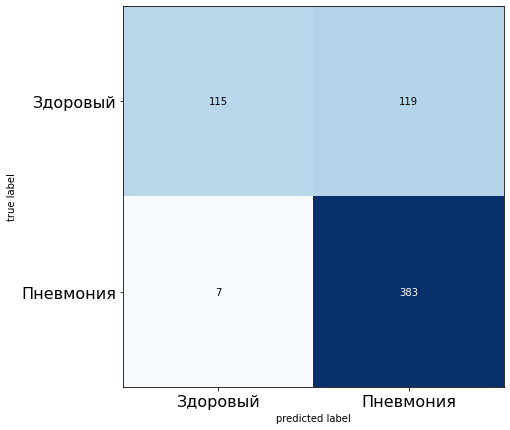

In [20]:
# строим confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(10,7), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Здоровый', 'Пневмония'], fontsize=16)
plt.yticks(range(2), ['Здоровый', 'Пневмония'], fontsize=16)
plt.show()

In [32]:
# рассчитаем метрики сети
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)

print("tn {:.2f}".format(tn/orig_test_labels.shape[0]))
print("fp {:.2f}".format(fp/orig_test_labels.shape[0]))
print("fn {:.2f}".format(fn/orig_test_labels.shape[0]))
print("tp {:.2f}".format(tp/orig_test_labels.shape[0]))

accuracy = (tp+tn) / (tn+fp+fn+tp)
precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("\nAccuracy of the model is {:.2f}".format(accuracy))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

115 119 7 383
tn 0.18
fp 0.19
fn 0.01
tp 0.61

Accuracy of the model is 0.80
Recall of the model is 0.98
Precision of the model is 0.76


In [22]:
#plt.plot(history.history['accuracy'], 
#         label='Доля верных ответов на обучающем наборе')
#plt.plot(history.history['val_accuracy'], 
#         label='Доля верных ответов на проверочном наборе')
#plt.xlabel('Эпоха обучения')
#plt.ylabel('Доля верных ответов')
#plt.legend()
#plt.show()
#
#plt.plot(history.history['loss'], 
#         label='Ошибка на обучающем наборе')
#plt.plot(history.history['val_loss'], 
#         label='Ошибка на проверочном наборе')
#plt.xlabel('Эпоха обучения')
#plt.ylabel('Ошибка')
#plt.legend()
#plt.show()

In [23]:
# загрузка изображений
def predict(path):
    counter = 1
    img_dir = Path(path) #pathlib
    print(img_dir)
    types = ('*.jpg', '*.jpeg', '*.png')
    glob_images = []
    
    #добавляем в list изображения всех типов
    for img in types:
        glob_images.extend(img_dir.glob(img))
        
    pred_img = []
    
    #унифицируем
    for img in glob_images:
        img = cv2.imread(str(img))
        img = cv2.resize(img, (224,224))
        if img.shape[2] ==1:
            img = np.dstack([img, img, img])
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)/255.
        label = to_categorical(0, num_classes=2)
        pred_img.append(img)
    
    #переводим в numpy массив для дальнейшей работы   
    images = np.array(pred_img)
    
    for img in images:
        #классифицируем
        predictions_single = model.predict(images)
        #вывод названия изображения
        print(glob_images[counter-1])
        #вывод вероятностей
        print("{} | Здоровый: {:.2f}".format(counter, predictions_single[counter-1][0]),
              " Больной: {:.2f}".format(predictions_single[counter-1][1]))
        #отрисовка изображений mathplotlib
        img = mimg.imread(glob_images[counter-1])
        imgplot = plt.imshow(img)
        plt.show()
        counter += 1

..\datasets
..\datasets\aaa.jpg
1 | Здоровый: 0.00  Больной: 1.00


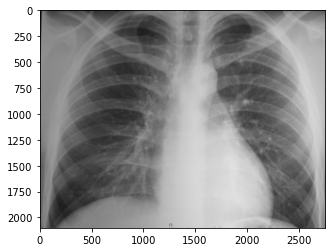

..\datasets\dvuhstoronyyaya-pnevmoniya.jpg
2 | Здоровый: 0.00  Больной: 1.00


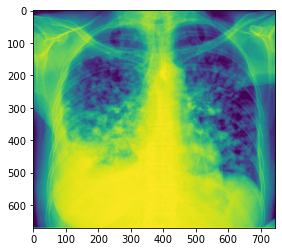

..\datasets\oslozhneniya-pnevmonii-detey-1B5DD71.jpg
3 | Здоровый: 1.00  Больной: 0.00


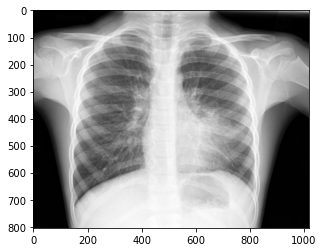

..\datasets\pneumo.jpg
4 | Здоровый: 1.00  Больной: 0.00


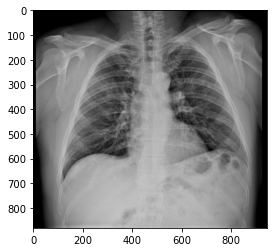

..\datasets\ppp.jpg
5 | Здоровый: 0.00  Больной: 1.00


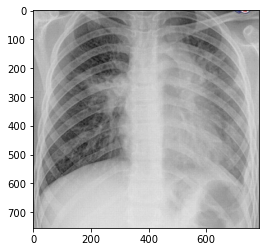

In [24]:
predict('../datasets/')